texture image size is (64, 64, 3)


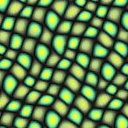

iter 2: loss:1139.05078125
iter 3: loss:1108.5110677083333
iter 4: loss:1067.8372395833333
iter 5: loss:1056.5559895833333
iter 6: loss:1047.9098307291667
iter 7: loss:1037.451171875
iter 8: loss:1037.1194661458333
iter 9: loss:1018.2327473958334
iter 10: loss:1022.0885416666666
iter 11: loss:1018.8193359375
iter 12: loss:1021.5940755208334
transiting!!! phase 1
iter 13: loss:1020.4153645833334
iter 14: loss:1017.084716796875
iter 15: loss:1004.057373046875
iter 16: loss:993.0635579427084
iter 17: loss:993.4693196614584
iter 18: loss:988.5484212239584
iter 19: loss:988.4917805989584
transiting!!! phase 2
iter 20: loss:843.22998046875
iter 21: loss:800.4205729166666
iter 22: loss:801.3009440104166
iter 23: loss:793.8388671875
iter 24: loss:789.419921875
iter 25: loss:786.4300130208334
iter 26: loss:784.6708170572916
iter 27: loss:785.3001302083334
iter 28: loss:785.1803385416666
transiting!!! phase 3
iter 29: loss:1002.8615112304688
iter 30: loss:998.5401204427084
iter 31: loss:994.8023

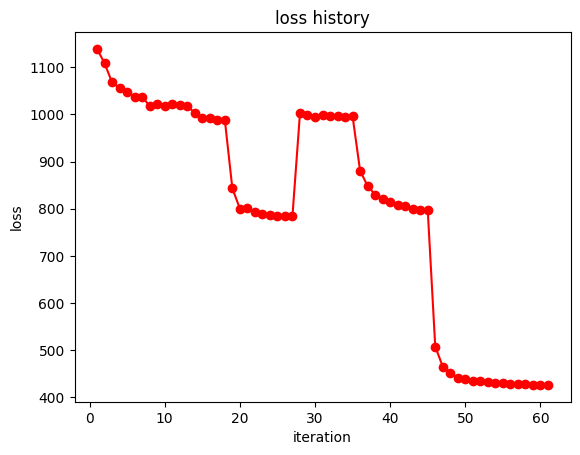

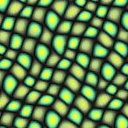

In [88]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image


### variables
path_to_texture_img = "sample_images/161.jpg"
target_width = 128

texture = cv2.imread(path_to_texture_img)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)


### item for algorithm
current_texture = cv2.resize(texture, (texture.shape[0] // 4, texture.shape[1] // 4))
current_target = cv2.resize(target, (target_width // 4, target_width // 4))
neighbor_width = 8


def init_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    texture_anchors[:, 0] = np.random.randint(
        0, current_texture.shape[0] - neighbor_width, size=len(target_anchors)
    )
    texture_anchors[:, 1] = np.random.randint(
        0, current_texture.shape[1] - neighbor_width, size=len(target_anchors)
    )
    return target_anchors, texture_anchors

target_anchors, texture_anchors = init_anchors(
    current_target.shape[0], neighbor_width, current_texture
)

def update_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            current_texture,
            current_target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, min_loc, _ = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

    return target_anchors, texture_anchors

loss_history = []
phase = 0
is_transiting = False

iter = 1
while iter < 100:
    iter += 1

    ### scheduling for neighbor_width and resolution
    if phase == 1 and is_transiting:
        transiting = False
        current_texture = cv2.resize(
            texture, (texture.shape[0] // 2, texture.shape[1] // 2)
        )
        current_target = cv2.resize(current_target, (target_width // 2, target_width // 2))
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 2 and is_transiting:
        neighbor_width = 8
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 3 and is_transiting:
        current_texture = texture
        current_target = cv2.resize(current_target, (target_width, target_width))
        neighbor_width = 32
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 4 and is_transiting:
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 5 and is_transiting:
        neighbor_width = 8
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 6:
        break

    # update target to argmin(E(target, texture))
    ref_for_pixel = [
        [] for _ in range(current_target.shape[0] * current_target.shape[1])
    ]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * current_target.shape[1] + (x + j)].append(
                    current_texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(current_target.shape[0]):
        for x in range(current_target.shape[1]):
            current_target[y, x] = np.mean(
                ref_for_pixel[y * current_target.shape[1] + x], axis=0
            )
            loss += np.sum(
                (ref_for_pixel[y * current_target.shape[1] + x] - current_target[y, x]) ** 2
            )

    mse = loss / (current_target.shape[0] * current_target.shape[1]) / 3
    print(f"iter {iter}: loss:{mse}")
    loss_history.append(mse)
    img_display.update(
        Image.fromarray(current_target)
    )

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()
    target_anchors, texture_anchors = update_anchors(
        current_target.shape[0], neighbor_width, current_texture
    )

    if np.all(texture_anchors == texture_anchors_prev) or mse in loss_history[-3:-1]:
        phase += 1
        is_transiting = True
        print(f"transiting!!! phase {phase}")


plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

target[:, :, :] = current_target
display(Image.fromarray(target))

now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_mul_texture_{now}.png")


以下は`I3_TextureSynthesis/denoising.ipynb`と比較する用の実験

texture image size is (36, 36, 3)


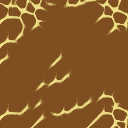

iter 2: loss:1249.3880208333333
iter 3: loss:1221.90234375
iter 4: loss:1217.115234375
transiting!!! phase 1
iter 5: loss:1164.7660319010417
transiting!!! phase 2
iter 6: loss:1295.937255859375
iter 7: loss:1212.0572102864583
iter 8: loss:1166.9195149739583
iter 9: loss:1147.639892578125
iter 10: loss:1131.995849609375
iter 11: loss:1119.43408203125
iter 12: loss:1107.1971028645833
iter 13: loss:1094.9906412760417
iter 14: loss:1092.4077962239583
iter 15: loss:1092.8929850260417
iter 16: loss:1087.518310546875
iter 17: loss:1086.485595703125
iter 18: loss:1085.0801595052083
iter 19: loss:1084.2307942708333
transiting!!! phase 3
iter 20: loss:1165.1344401041667
transiting!!! phase 4
iter 21: loss:1096.159932454427
iter 22: loss:1044.7479451497395
iter 23: loss:1006.68408203125
iter 24: loss:996.5887451171875
iter 25: loss:987.6089070638021
iter 26: loss:982.70556640625
iter 27: loss:980.3465779622396
iter 28: loss:978.1897176106771
iter 29: loss:977.7986653645834
transiting!!! phase 5
i

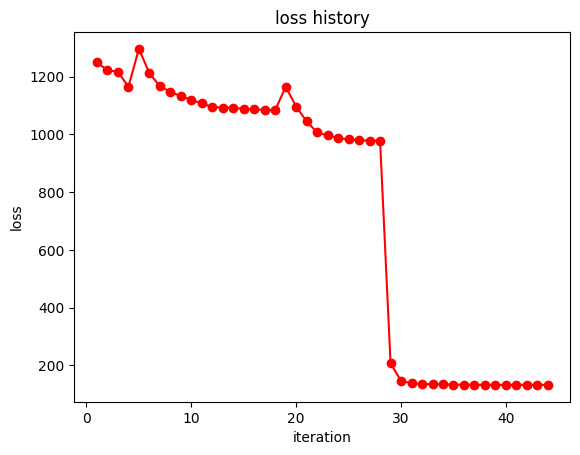

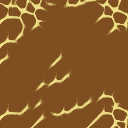

In [94]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image


### variables
path_to_texture_img = "sample_images/kirin_64.jpg"
target_width = 128

texture = cv2.imread(path_to_texture_img)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
texture = cv2.resize(texture, (36, 36))
print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)


### item for algorithm
current_texture = cv2.resize(texture, (texture.shape[0] // 4, texture.shape[1] // 4))
current_target = cv2.resize(target, (target_width // 4, target_width // 4))
neighbor_width = 8


def init_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    texture_anchors[:, 0] = np.random.randint(
        0, current_texture.shape[0] - neighbor_width, size=len(target_anchors)
    )
    texture_anchors[:, 1] = np.random.randint(
        0, current_texture.shape[1] - neighbor_width, size=len(target_anchors)
    )
    return target_anchors, texture_anchors

target_anchors, texture_anchors = init_anchors(
    current_target.shape[0], neighbor_width, current_texture
)

def update_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            current_texture,
            current_target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, min_loc, _ = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

    return target_anchors, texture_anchors

loss_history = []
phase = 0
is_transiting = False

iter = 1
while iter < 100:
    iter += 1

    ### scheduling for neighbor_width and resolution
    if phase == 1 and is_transiting:
        transiting = False
        current_texture = cv2.resize(
            texture, (texture.shape[0] // 2, texture.shape[1] // 2)
        )
        current_target = cv2.resize(current_target, (target_width // 2, target_width // 2))
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 2 and is_transiting:
        neighbor_width = 8
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 3 and is_transiting:
        current_texture = texture
        current_target = cv2.resize(current_target, (target_width, target_width))
        neighbor_width = 32
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 4 and is_transiting:
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 5 and is_transiting:
        neighbor_width = 8
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if phase == 6:
        break

    # update target to argmin(E(target, texture))
    ref_for_pixel = [
        [] for _ in range(current_target.shape[0] * current_target.shape[1])
    ]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * current_target.shape[1] + (x + j)].append(
                    current_texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(current_target.shape[0]):
        for x in range(current_target.shape[1]):
            current_target[y, x] = np.mean(
                ref_for_pixel[y * current_target.shape[1] + x], axis=0
            )
            loss += np.sum(
                (ref_for_pixel[y * current_target.shape[1] + x] - current_target[y, x]) ** 2
            )

    mse = loss / (current_target.shape[0] * current_target.shape[1]) / 3
    print(f"iter {iter}: loss:{mse}")
    loss_history.append(mse)
    img_display.update(
        Image.fromarray(current_target)
    )

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()
    target_anchors, texture_anchors = update_anchors(
        current_target.shape[0], neighbor_width, current_texture
    )

    if np.all(texture_anchors == texture_anchors_prev) or mse in loss_history[-3:-1]:
        phase += 1
        is_transiting = True
        print(f"transiting!!! phase {phase}")


plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

target[:, :, :] = current_target
display(Image.fromarray(target))

now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_mul_texture_{now}.png")